# Vector Quantization and Hierarchical K-means clustering
## Dataset: MNIST
![alt text](https://drive.google.com/uc?id=1hiGIhQX25NypR-BpNBdfI57I3tOfU4Jf)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My Drive/CS498

/content/gdrive/My Drive/CS498


In [0]:
ls

'cluster center from level 1.png'   MNISTdata.hdf5    train_feat_new
 data/                              test_feat_new     train_feat_new_2
 mnist_aml.ipynb                    test_feat_new_2   Untitled0.ipynb


In [0]:
# Dependencies

import numpy as np
import pandas as pd
from sklearn import metrics
import h5py
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
import time
from itertools import product
import pickle
import argparse
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [0]:
# Loading the Dataset
def loadMNIST(prefix, folder):
  intType = np.dtype( 'int32' ).newbyteorder( '>' )
  nMetaDataBytes = 4 * intType.itemsize

  data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
  magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
  data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

  labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                        dtype = 'ubyte' )[2 * intType.itemsize:]
  return data, labels


In [0]:
# Training Data
train_x, train_y = loadMNIST('train','data')

In [0]:
# Test Data
test_x, test_y = loadMNIST('t10k','data')

In [0]:
# Visualize a random sample from the Dataset
def disp_image(data):
  total_samples, m ,n = data.shape
  sample = np.random.randint(0,total_samples)
  img = data[sample]
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.show()

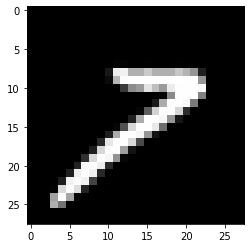

In [0]:
# Training Data (Visualize)
disp_image(train_x)

In [0]:
# Extract Patches
def image_to_patches(img, add_offsets):
  # img: (28, 28)
  # Returns: patches = (16, 10, 10) patches for add_offsets = False
  # Returns: patches = (144, 10, 10) patches for add_offsets = True

  # This Dataset for creating clusters and dictionaries of datasets
  if not add_offsets:
      patches = np.zeros((16, 10, 10))
      for count, (i, j) in enumerate(product(range(0, 20, 6), range(0, 20, 6))):
          patch = img[i:i+10,j:j+10]
          patches[count] = patch
      return patches

  # If adding offsets ( Later for creating features for histograms)
  patches = np.zeros((144, 10, 10))
  pad_img = np.pad(img, 1)
  count = 0
  for i,j in product(range(1, 21, 6), range(1, 21, 6)):
      coords = [(i-1, j-1), (i, j-1), (i+1, j-1), (i-1, j), (i, j), (i+1, j), (i-1, j+1), (i, j+1), (i+1, j+1)]
      for coord in coords:
          patch = pad_img[coord[0]:coord[0]+10,coord[1]:coord[1]+10]
          patches[count] = patch
          count += 1
  return patches


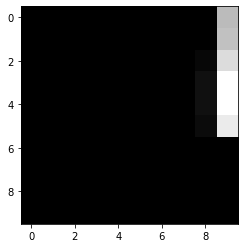

In [0]:
# Visulazing patches
sample = np.random.randint(0,60000)
patch_img = train_x[sample]
patch_data_viz = image_to_patches(patch_img, False) # Contains 16 patches obtained from patch_img
disp_image(patch_data_viz) # A random patch from the 16 patches

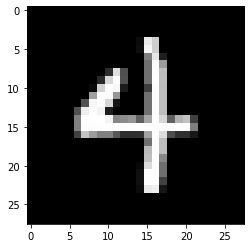

In [0]:
# For reference visualize the patch_img
plt.imshow(patch_img, cmap = plt.get_cmap('gray'))

In [0]:
# Visualize all patches for a single random MNIST image
def patch_viz(patches_data):
  #N, p, q = patches_data.shape
  fig, axes = plt.subplots(nrows=4,ncols=4)
  for count, (i, j) in enumerate(product(range(0, 4, 1), range(0, 4, 1))):
    axes[i,j].imshow(patches_data[count], cmap=plt.get_cmap('gray'))
  plt.show()


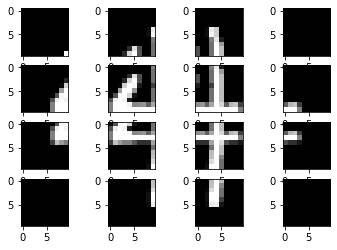

In [0]:
patch_viz(patch_data_viz)

In [0]:
# Create a dataset of 60,000 patches (Choosing 1 random patch from 16 patches, from each of the 60000 images)
def produce_patches16(data_x):
  feat = data_x
  train_patch = np.zeros((feat.shape[0] ,10, 10))
  for count, img in enumerate(feat):
      patches = image_to_patches(img, add_offsets=False)
      idx = np.random.choice(16)
      patch = patches[idx]
      train_patch[count] = patch
  return train_patch

In [0]:
# Patch Dataset
train_patch = produce_patches16(train_x)

In [0]:
# Study the new dataset
train_patch.shape

(60000, 10, 10)

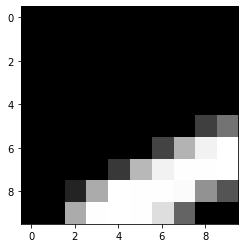

In [0]:
# Visualize
disp_image(train_patch)

In [0]:
# Helper Functions

# Flatten each image
def vectorize(data):
  num_sample, m, n = data.shape
  vector = data.reshape(num_sample,m*n)
  return vector

# Extract n random samples with replacement from the dataset
def sub_sample(data,n):
  rng = np.random.default_rng()
  sub_size = rng.choice(60000,size=n,replace=False)
  sub_data = data[sub_size,:,:]
  return sub_data

# Perform k-means clustering on sub sample dataset and predict cluster centers of the parent dataset 
# returns cluster centers list (60000,) and kmeans cluster model
def k_means_cluster(n,sub_data,data):
  X = sub_data
  Y = data
  x_fit = KMeans(n_clusters=n).fit(X)
  predict = x_fit.predict(Y)
  return predict, x_fit

In [0]:
# Level 1 Dictionary

# sub-sample patch dataset
sub_patches = sub_sample(train_patch, 6000)

In [0]:
# Flatten the images to 100 dim vectors
sub_patches_vec = vectorize(sub_patches)
patches_vec = vectorize(train_patch)

In [0]:
# check
shp_a = sub_patches_vec.shape
shp_b = patches_vec.shape
print('The shape of training patches is',shp_b,'and the shape of sub-sample patches is',shp_a)

The shape of training patches is (60000, 100) and the shape of sub-sample patches is (6000, 100)


In [0]:
print('Performing K-Means clustering at Level-1')
clus_vec, lvl_1_model = k_means_cluster(10,sub_patches_vec,patches_vec)

Performing K-Means clustering at Level-1


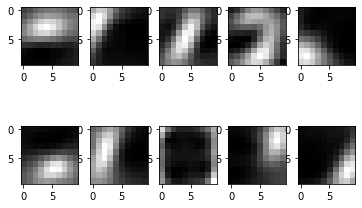

In [0]:
# Visulaize cluster centers
lvl1_cntr = lvl_1_model.cluster_centers_
# Reshape for visualization
clust1_centers = lvl1_cntr.reshape(10,10,10)
fig, axes = plt.subplots(nrows=2,ncols=5)
for count, (i, j) in enumerate(product(range(0, 2, 1), range(0, 5, 1))):
  axes[i,j].imshow(clust1_centers[count], cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
# Seperating the 60,000 patches into their respective clusters to form a dictionary of datasets
def data_dict_one(data,vec,k):
  lev1_dict = {}
  for i in range(k):
    for j in range(len(vec)):
      if vec[j] == i:
        lev1_dict.setdefault(i,[]).append(data[j])
  return lev1_dict

In [0]:
data_dict_1 = data_dict_one(train_patch,clus_vec,10)

In [0]:
# Let us visualize one random data item from a randomly chosen dataset of this dictionary
# total datasets = K
rand_num = np.random.randint(10)
dataset = data_dict_1[rand_num]
dataset = np.stack(dataset,axis=0)
items, row, col = dataset.shape
print('This is Dataset belonging to cluster:',rand_num,'It has',items,'data items in it.')

This is Dataset belonging to cluster: 9 It has 4626 data items in it.


In [0]:
print('This dataset has the shape:',dataset.shape)

This dataset has the shape: (4626, 10, 10)


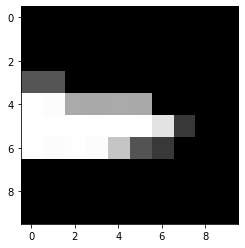

In [0]:
# Visualize a random image from the dataset selected above
disp_image(dataset)

In [0]:
# Now we perform Level 2 clustering
def data_dict_two(dict_one):
  lvl2_dict = {}
  clus_models = []
  m = len(dict_one)
  for i in range(m):
    data_x = dict_one[i]
    data_x = np.stack(data_x,axis=0)
    samples, p, q = data_x.shape
    data_x = vectorize(data_x)
    clus_vec, model = k_means_cluster(10,data_x,data_x)
    clus_models.append(model)
    data_x = data_x.reshape(samples,p,q)
    level1 = data_dict_one(data_x,clus_vec,m)
    lvl2_dict[i] = level1
  return lvl2_dict, clus_models


In [0]:
data_dict_2, clus_models = data_dict_two(data_dict_1)

These cluster centers belong to cluster: 9 from Level 1 clusters


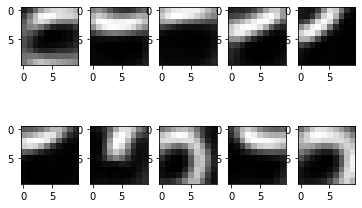

In [0]:
# Let us visualize cluster centers of a randomly chosen model from the level 2 models list
# total datasets = K
rand_num = np.random.randint(10)
print('These cluster centers belong to cluster:',rand_num,'from Level 1 clusters')
lvl_2_model = clus_models[rand_num]
# Visulaize cluster centers
lvl2_cntr = lvl_2_model.cluster_centers_
# Reshape for visualization
clust2_centers_viz = lvl2_cntr.reshape(10,10,10)
fig2, axes2 = plt.subplots(nrows=2,ncols=5)
for count, (i, j) in enumerate(product(range(0, 2, 1), range(0, 5, 1))):
  axes2[i,j].imshow(clust2_centers_viz[count], cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
def level_1_map(patch,model):
  return model.predict(patch.reshape(1, -1))[0]

def level_2_map(clus_model,patch,models):
  lv1 = level_1_map(patch, clus_model)
  model = models[lv1]
  lvl2_id = model.predict(patch.reshape(1, -1))[0]
  final_id = 10*lv1+lvl2_id
  return final_id


In [0]:
def patch_to_ids(patches,clus_model_1,clus_models_2):
  patches = vectorize(patches)
  cluster_list = []
  for patch in patches:
    level1_id = level_1_map(patch,clus_model_1)
    level2_id = level_2_map(level1_id, patch, clus_models_2)
    cluster_list.append(level2_id)
  return cluster_list

In [0]:
# Generate the features for training and testing
def histogram_features(data,clus_model_1,clus_models_2):
  features = []
  for i in data:
    patches = image_to_patches(i,True) # (144 x 10 x 10) patches
    cluster_list = patch_to_ids(patches,clus_model_1,clus_models_2)
    hist, arr = np.histogram(cluster_list,bins=list(range(101)))
    features.append(hist)
  return features


In [0]:
# Training features
train_features_hist = histogram_features(train_x,lvl_1_model,clus_models)
pickle.dump(train_features_hist, open('train_feat_new', 'wb'))

In [0]:
# Test features
test_features_hist = histogram_features(test_x,lvl_1_model,clus_models)
pickle.dump(test_features_hist, open('test_feat_new', 'wb'))

In [0]:
# Load pickle files
train_hist_feat = pickle.load(open('train_feat_new_2', 'rb'))
test_hist_feat = pickle.load(open('test_feat_new_2', 'rb'))


In [0]:
hist_feats = np.stack(train_hist_feat,axis=0)
hist_feats.shape

(60000, 2500)

In [0]:
# Lets visualize the histograms ( Checks )
# On checking several labels label[0] and label[11] correspond to 5 
# label[6] = 1 ( This contains a different stroke compared to 5)
label_1 = train_y[0] #5
label_2 = train_y[11] #5
label_3 = train_y[6] #1
data_item_1 = train_hist_feat[0]
data_item_2 = train_hist_feat[11]
data_item_3 = train_hist_feat[6]
print('This check plots histograms of feature signals for number',label_1,'and',label_2,'and compares it with',label_3)

This check plots histograms of feature signals for number 5 and 5 and compares it with 1


In [0]:
print('The shapes of the signals for data items 1,2,3 are respectively:',data_item_1.shape,data_item_2.shape,data_item_3.shape)

The shapes of the signals for data items 1,2,3 are respectively: (2500,) (2500,) (2500,)


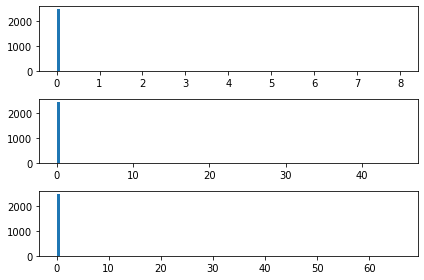

In [0]:
#data_item_1 = data_item_1.reshape(1,100)
fig, axs = plt.subplots(3, 1, tight_layout=True)
axs[0].hist(data_item_1,bins=101)
axs[1].hist(data_item_2,bins=101)
axs[2].hist(data_item_3,bins=101)
plt.show()

In [0]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=None)

In [0]:
classifier.fit(train_hist_feat,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pred = classifier.predict(test_hist_feat)
acc = metrics.accuracy_score(test_y, pred)


In [0]:
print(acc)

0.919


In [0]:
def image_to_clusters(img, clus, cluster_mapping):
  cluster_list = []
  patches = image_to_patches(img, add_offsets=True)
  patches_vec = vectorize(patches)
  for patch in patches_vec:
      cluster_id = level_2_map(clus, patch, cluster_mapping)
      cluster_list.append(cluster_id)
  return cluster_list

def image_to_histogram(img, clus, cluster_mapping):
  cluster_list = image_to_clusters(img, clus, cluster_mapping)
  hist, arr = np.histogram(cluster_list, bins=list(range(2501)))
  return hist



In [0]:
def process_data(data, clus, clus_models):
  data_list = []
  for i in data:
    data_list.append(image_to_histogram(i, clus, clus_models))
  return data_list


In [0]:
train_feat_2 = process_data(train_x, lvl_1_model, clus_models)
pickle.dump(train_feat_2, open('train_feat_new_2', 'wb'))
test_feat_2 = process_data(test_x, lvl_1_model, clus_models)
pickle.dump(test_feat_2, open('test_feat_new_2', 'wb'))

In [0]:
classifier2 = RandomForestClassifier(n_estimators=100, max_depth=None)

In [0]:
classifier2.fit(train_feat_2,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pred2 = classifier2.predict(test_feat_2)
acc = metrics.accuracy_score(test_y, pred2)


In [0]:
print(acc)

0.9202


# Performing the process for 2500 clusters

In [0]:
# New Dataset
print('Performing K-Means clustering at Level-1\n')
clus_vec_new, lvl_1_model_new = k_means_cluster(50,sub_patches_vec,patches_vec)
print('Clusters at Level-1 created\n')
print('Creating Level-1 datasets\n')
data_dict_1_new = data_dict_one(train_patch,clus_vec_new,50)
print('Level-1 datasets created\n')
print('Creating Level-2 datasets\n')
data_dict_2_new, clus_models_new = data_dict_two(data_dict_1_new)
print('Level-2 datasets created\n')

Performing K-Means clustering at Level-1

Clusters at Level-1 created

Creating Level-1 datasets

Level-1 datasets created

Creating Level-2 datasets

Level-2 datasets created



In [0]:
# Creating features
print('Creating Training Features\n')
train_feat_2500_new = process_data(train_x, lvl_1_model_new, clus_models_new)
pickle.dump(train_feat_2500_new, open('train_feat_2500_new', 'wb'))
print('Training features created\n')
print('Creating Test Features\n')
test_feat_2500_new = process_data(test_x, lvl_1_model_new, clus_models_new)
pickle.dump(test_feat_2500_new, open('test_feat_2500_new', 'wb'))
print('Test features created\n')

Creating Training Features

Training features created

Creating Test Features

Test features created



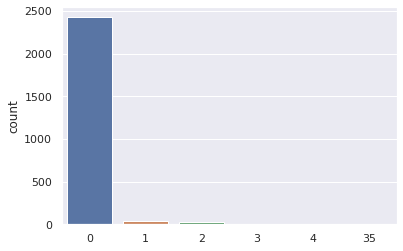

In [0]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(train_feat_2500_new[100])


In [0]:
Counter(train_feat_2500_new[19])

Counter({0: 2428, 1: 47, 2: 16, 3: 7, 4: 1, 40: 1})

In [0]:
# Load saved dataset
train_feat_2500 = pickle.load(open('train_feat_2500_new', 'rb'))
test_feat_2500 = pickle.load(open('test_feat_2500_new', 'rb'))
